# Quantizing RNN Models

In this example, we show how to quantize recurrent models.  
Using a pretrained model `model.RNNModel`, we convert the built-in pytorch implementation of LSTM to our own, modular implementation.  
The pretrained model was generated with:  
```time python3 main.py --cuda --emsize 1500 --nhid 1500 --dropout 0.65 --tied --wd=1e-6```  
The reason we replace the LSTM that is because the inner operations in the pytorch implementation are not accessible to us, but we still want to quantize these operations. <br />
Afterwards we can try different techniques to quantize the whole model.  

_NOTE_: We use `tqdm` to plot progress bars, since it's not in `requirements.txt` you should install it using 
`pip install tqdm`.

In [1]:
from model import DistillerRNNModel, RNNModel
from data_wikitext.data import Corpus
import torch
from torch import nn
import distiller
from distiller.modules import DistillerLSTM as LSTM
from tqdm import tqdm # for pretty progress bar
import numpy as np
from copy import deepcopy

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hguan2/anaconda2/envs/distiller

### Preprocess the data

In [2]:
corpus = Corpus('./data_wikitext/data/wikitext-2/')

In [3]:
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)
device = 'cuda:0'
batch_size = 20
eval_batch_size = 10
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

### Loading the model and converting to our own implementation

In [4]:
rnn_model = torch.load('./logs/lstm/checkpoint.pth.tar.best')
rnn_model = rnn_model.to(device)
rnn_model

RNNModel(
  (drop): Dropout(p=0.65)
  (encoder): Embedding(33278, 1500)
  (rnn): LSTM(1500, 1500, num_layers=2, dropout=0.65)
  (decoder): Linear(in_features=1500, out_features=33278, bias=True)
)

Here we convert the pytorch LSTM implementation to our own, by calling `LSTM.from_pytorch_impl`:

In [5]:
def manual_model(pytorch_model_: RNNModel):
    nlayers, ninp, nhid, ntoken, tie_weights = \
        pytorch_model_.nlayers, \
        pytorch_model_.ninp, \
        pytorch_model_.nhid, \
        pytorch_model_.ntoken, \
        pytorch_model_.tie_weights

    model = DistillerRNNModel(nlayers=nlayers, ninp=ninp, nhid=nhid, ntoken=ntoken, tie_weights=tie_weights).to(device)
    model.eval()
    model.encoder.weight = nn.Parameter(pytorch_model_.encoder.weight.clone().detach())
    model.decoder.weight = nn.Parameter(pytorch_model_.decoder.weight.clone().detach())
    model.decoder.bias = nn.Parameter(pytorch_model_.decoder.bias.clone().detach())
    model.rnn = LSTM.from_pytorch_impl(pytorch_model_.rnn)

    return model

man_model = manual_model(rnn_model)
torch.save(man_model, './logs/lstm/manual.checkpoint.pth.tar')
man_model

DistillerRNNModel(
  (encoder): Embedding(33278, 1500)
  (rnn): DistillerLSTM(1500, 1500, num_layers=2, dropout=0.65, bidirectional=False)
  (decoder): Linear(in_features=1500, out_features=33278, bias=True)
)

### Batching the data for evaluation

In [6]:
sequence_len = 35
def get_batch(source, i):
    seq_len = min(sequence_len, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

hidden = rnn_model.init_hidden(eval_batch_size)
data, targets = get_batch(test_data, 0)

### Check that the convertion has succeeded

In [7]:
rnn_model.eval()
man_model.eval()
y_t, h_t = rnn_model(data, hidden)
y_p, h_p = man_model(data, hidden)

print("Max error in y: %f" % (y_t-y_p).abs().max().item())

Max error in y: 0.000006


### Defining the evaluation

In [8]:
criterion = nn.CrossEntropyLoss()
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
    

def evaluate(model, data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        with tqdm(range(0, data_source.size(0), sequence_len)) as t:
            # The line below was fixed as per: https://github.com/pytorch/examples/issues/214
            for i in t:
                data, targets = get_batch(data_source, i)
                output, hidden = model(data, hidden)
                output_flat = output.view(-1, ntokens)
                total_loss += len(data) * criterion(output_flat, targets).item()
                hidden = repackage_hidden(hidden)
                avg_loss = total_loss / (i + 1)
                t.set_postfix((('val_loss', avg_loss), ('ppl', np.exp(avg_loss))))
    return total_loss / len(data_source)

# Quantizing the Model

## Collect activation statistics

The model uses activation statistics to determine how big the quantization range is. The bigger the range - the larger the round off error after quantization which leads to accuracy drop.  
Our goal is to minimize the range s.t. it contains the absolute most of our data.  
After that, we divide the range into chunks of equal size, according to the number of bits, and transform the data according to this scale factor.  
Read more on scale factor calculation [in our docs](https://nervanasystems.github.io/distiller/algo_quantization.html).

The class `QuantCalibrationStatsCollector` collects the statistics for defining the range $r = max - min$.  

Each forward pass, the collector records the values of inputs and outputs, for each layer:
- absolute over all batches min, max (stored in `min`, `max`)
- average over batches, per batch min, max (stored in `avg_min`, `avg_max`)
- mean
- std
- shape of output tensor  

All these values can be used to define the range of quantization, e.g. we can use the absolute `min`, `max` to define the range.

In [9]:
import os
from distiller.data_loggers import QuantCalibrationStatsCollector, collector_context

man_model = torch.load('./logs/lstm/manual.checkpoint.pth.tar')
distiller.utils.assign_layer_fq_names(man_model)
collector = QuantCalibrationStatsCollector(man_model)

if not os.path.isfile('/logs/lstm/manual_lstm_pretrained_stats.yaml'):
    with collector_context(collector) as collector:
        val_loss = evaluate(man_model, val_data)
        collector.save('./logs/lstm/manual_lstm_pretrained_stats.yaml')

100%|██████████| 622/622 [10:42<00:00,  1.03it/s, val_loss=4.47, ppl=87.3] 


## Prepare the Model For Quantization
  
We quantize the model after the training has completed.  
Here we check the baseline model perplexity, to have an idea how good the quantization is.

In [10]:
from distiller.quantization import PostTrainLinearQuantizer, LinearQuantMode
from copy import deepcopy

# Load and evaluate the baseline model.
man_model = torch.load('./logs/lstm/manual.checkpoint.pth.tar')
val_loss = evaluate(man_model, val_data)
print('val_loss:%8.2f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

100%|██████████| 622/622 [00:20<00:00, 31.06it/s, val_loss=4.47, ppl=87.3]

val_loss:    4.46	|	 ppl:   86.79


Now we do our magic - __Preparing the model for quantization__.  
The quantizer replaces the layers in out model with their quantized versions.  

In [11]:
# Define the quantizer
quantizer = PostTrainLinearQuantizer(
    deepcopy(man_model),
    model_activation_stats='./logs/lstm/manual_lstm_pretrained_stats.yaml')

# Quantizer magic
stats_before_prepare = deepcopy(quantizer.model_activation_stats)
dummy_input = (torch.zeros(1,1).to(dtype=torch.long), man_model.init_hidden(1))
quantizer.prepare_model(dummy_input)

### Net-Aware Quantization

Note that we passes a dummy input to `prepare_model`. This is required for the quantizer to be able to create a graph representation of the model, and to infer the connectivity between the modules.  
Understanding the connectivity of the model is required to enable **"Net-aware quantization"**. This term (coined in [\[1\]](#references), section 3.2.2), means we can achieve better quantization by considering sequences of operations.  
In the case of LSTM, we have an element-wise add operation whose output is split into 4 and fed into either Tanh or Sigmoid activations. Both of these ops saturate at relatively small input values - tanh at approximately $|4|$, and sigmoid saturates at approximately $|6|$. This means we can safely clip the output of the element-wise add operation between $[-6,6]$. `PostTrainLinearQuantizer` detects this patterm and modifies the statistics accordingly.

In [12]:
import pprint
pp = pprint.PrettyPrinter(indent=1)
print('Stats BEFORE prepare_model:')
pp.pprint(stats_before_prepare['rnn.cells.0.eltwiseadd_gate']['output'])

print('\nStats AFTER to prepare_model:')
pp.pprint(quantizer.model_activation_stats['rnn.cells.0.eltwiseadd_gate']['output'])

Stats BEFORE prepare_model:
OrderedDict([('min', -13.792905807495117),
             ('max', 15.628253936767578),
             ('avg_min', -6.517626995670698),
             ('avg_max', 5.397376813044116),
             ('mean', -0.8030920241080964),
             ('std', 1.3721356902378938),
             ('shape', '(10, 6000)')])

Stats AFTER to prepare_model:
OrderedDict([('min', -6.0),
             ('max', 6.0),
             ('avg_min', -6.0),
             ('avg_max', 5.397376813044116),
             ('mean', -0.8030920241080964),
             ('std', 1.3721356902378938),
             ('shape', '(10, 6000)')])


Note the value for `avg_max` did not change, since it was already below the clipping value of $6.0$.

### Inspecting the Quantized Model

Let's see how the model has after being prepared for quantization:

In [13]:
quantizer.model

DistillerRNNModel(
  (encoder): RangeLinearEmbeddingWrapper(
    (wrapped_module): Embedding(33278, 1500)
  )
  (rnn): DistillerLSTM(1500, 1500, num_layers=2, dropout=0.65, bidirectional=False)
  (decoder): RangeLinearQuantParamLayerWrapper(
    mode=SYMMETRIC, num_bits_acts=8, num_bits_params=8, num_bits_accum=32, clip_acts=NONE, per_channel_wts=False, scale_approx_mult_bits=None
    preset_activation_stats=True
    w_scale=123.2932, w_zero_point=0.0000
    in_scale=127.0020, in_zero_point=0.0000
    out_scale=3.8359, out_zero_point=0.0000
    (wrapped_module): Linear(in_features=1500, out_features=33278, bias=True)
  )
)

Note how `encoder` and `decoder` have been replaced with wrapper layers (for the relevant module type), which handle the quantization. The same holds for the internal layers of the `DistillerLSTM` module, which we don't print for brevity sake. To "peek" inside the `DistillerLSTM` module, we need to access it directly. As an example, let's take a look at a couple of the internal layers:

In [14]:
print(quantizer.model.rnn.cells[0].fc_gate_x)
print(quantizer.model.rnn.cells[0].eltwiseadd_gate)

RangeLinearQuantParamLayerWrapper(
  mode=SYMMETRIC, num_bits_acts=8, num_bits_params=8, num_bits_accum=32, clip_acts=NONE, per_channel_wts=False, scale_approx_mult_bits=None
  preset_activation_stats=True
  w_scale=163.0813, w_zero_point=0.0000
  in_scale=123.2932, in_zero_point=0.0000
  out_scale=15.6020, out_zero_point=0.0000
  (wrapped_module): Linear(in_features=1500, out_features=6000, bias=True)
)
RangeLinearQuantEltwiseAddWrapper(
  mode=SYMMETRIC, num_bits_acts=8, num_bits_accum=32, clip_acts=NONE, scale_approx_mult_bits=None
  preset_activation_stats=True
  in_0_scale=15.601971626281738, in_0_zero_point=0.0
  in_1_scale=8.754857063293457, in_1_zero_point=0.0
  out_scale=21.166667938232422, out_zero_point=0.0
  (wrapped_module): EltwiseAdd()
)


In [15]:
# print(quantizer.model.encoder)

## Running the Quantized Model

### Try 1: Initial settings - simple symmetric quantization

Finally, let's go ahead and evaluate the quantized model:

In [16]:
# val_loss = evaluate(quantizer.model.to(device), val_data)
# print('val_loss:%8.2f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

As we can see here, the perplexity has increased much - meaning our quantization has damaged the accuracy of our model.

### Try 2: Assymetric, per-channel

Let's try quantizing each channel separately, and making the range of the quantization asymmetric.

In [17]:
# quantizer = PostTrainLinearQuantizer(
#     deepcopy(man_model),
#     model_activation_stats='./manual_lstm_pretrained_stats.yaml',
#     mode=LinearQuantMode.ASYMMETRIC_SIGNED,
#     per_channel_wts=True
# )
# quantizer.prepare_model(dummy_input)
# quantizer.model

In [18]:
# val_loss = evaluate(quantizer.model.to(device), val_data)
# print('val_loss:%8.2f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

A tiny bit better, but still no good.

### Try 3: Mixed FP16 and INT8

Let us try the half precision (aka FP16) version of the model:

In [19]:
# model_fp16 = deepcopy(man_model).half()
# val_loss = evaluate(model_fp16, val_data)
# print('val_loss: %8.6f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

The result is very close to our original model! That means that the roundoff when quantizing linearly to 8-bit integers is what hurts our accuracy.

Luckily, `PostTrainLinearQuantizer` supports quantizing some/all layers to FP16 using the `fp16` parameter. In light of what we just saw, and as stated in [\[2\]](#References), let's try keeping element-wise operations at FP16, and quantize everything else to 8-bit using the same settings as in try 2.

In [20]:
# overrides_yaml = """
# .*eltwise.*:
#     fp16: true
# encoder:
#     fp16: true
# decoder:
#     fp16: true
# """
# overrides = distiller.utils.yaml_ordered_load(overrides_yaml)
# quantizer = PostTrainLinearQuantizer(
#     deepcopy(man_model),
#     model_activation_stats='./manual_lstm_pretrained_stats.yaml',
#     mode=LinearQuantMode.ASYMMETRIC_SIGNED,
#     overrides=overrides,
#     per_channel_wts=True
# )
# quantizer.prepare_model(dummy_input)
# quantizer.model

In [21]:
# val_loss = evaluate(quantizer.model.to(device), val_data)
# print('val_loss:%8.6f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

The accuracy is still holding up very well, even though we quantized the inner linear layers!  

### Try 4: Clipping Activations

Now, lets try to choose different boundaries for `min`, `max`.  
Instead of using absolute ones, we take the average of all batches (`avg_min`, `avg_max`), which is an indication of where usually most of the boundaries lie. This is done by specifying the `clip_acts` parameter to `ClipMode.AVG` or `"AVG"` in the quantizer ctor:

In [22]:
# overrides_yaml = """
# encoder:
#     fp16: true
# decoder:
#     fp16: true
# """
# overrides = distiller.utils.yaml_ordered_load(overrides_yaml)
# quantizer = PostTrainLinearQuantizer(
#     deepcopy(man_model),
#     model_activation_stats='./manual_lstm_pretrained_stats.yaml',
#     mode=LinearQuantMode.ASYMMETRIC_SIGNED,
#     overrides=overrides,
#     per_channel_wts=True,
#     clip_acts="AVG"
# )
# quantizer.prepare_model(dummy_input)
# val_loss = evaluate(quantizer.model.to(device), val_data)
# print('val_loss:%8.6f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

Great! Even though we quantized all of the layers except the embedding and the decoder - we got almost no accuracy penalty. Lets try quantizing them as well:

In [23]:
quantizer = PostTrainLinearQuantizer(
    deepcopy(man_model),
    model_activation_stats='./logs/lstm/manual_lstm_pretrained_stats.yaml',
    mode=LinearQuantMode.ASYMMETRIC_SIGNED,
    per_channel_wts=True,
    clip_acts="AVG"
)
quantizer.prepare_model(dummy_input)
val_loss = evaluate(quantizer.model.to(device), val_data)
print('val_loss:%8.6f\t|\t ppl:%8.2f' % (val_loss, np.exp(val_loss)))

100%|██████████| 622/622 [02:20<00:00,  4.68it/s, val_loss=4.53, ppl=92.6] 

val_loss:4.521964	|	 ppl:   92.02


In [45]:

import numpy as np
import os, shutil 

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision 
from fault_injection import * 
import pickle, time, collections
from datetime import datetime  
import distiller 
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42

class Args(object):
    pass 
args = Args() 
args.no_cuda = False 
args.seed = 1 
args.save='./logs'
torch.manual_seed(args.seed)

args.cuda = not args.no_cuda and torch.cuda.is_available()
print('using GPU:', args.cuda)

using GPU: True


# weights distribution

In [58]:
model_name = 'lstm'
def plot_model_dist(model):
    
    # check the distribution of parameters all weights
    thr = 32
    total_values, num_weights = 0, 0 
    counter = collections.Counter()
    for param_name, param in model.named_parameters():
        total_values += param.nelement()
        if len(param.size()) < 2:
            continue
        num_weights += param.nelement()
#         print('param_name', param_name)
#         print('param: min,max', np.min(param.data.cpu().numpy()), np.max(param.data.cpu().numpy()))
        counter.update(collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr +1))

    tmp = sorted(counter.items(), key=lambda x: x[0])
    values, counts = zip(*tmp)
    print('before merge')
    print('values:', values)
    print('counts:', counts)
    
    # merge the interval [64, 96] and [96, 128]. In case there is 128, #counts=5 need to merge the last three intervals. 
    values = list(values)[:3]
    counts = list(counts)
    counts[2] += sum(counts[3:])
    counts = counts[:3]
    print('after merge:')
    print('values', values)
    print('counts', counts)

    total_weights = sum(list(counts))
    assert total_weights == num_weights
    print('#weights:', total_weights, ', #params:', total_values, 'percentage:', '%.6f' %(num_weights/total_values))
    
    fontsize = 16
    percentages = [count*100/total_weights for count in counts]
    bar = plt.bar(values, percentages)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f%%' %(height), ha='center', va='bottom', fontsize = 16)
    print(['%.2f' %(p) for p in percentages])
    #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
    # plt.xticks(values, [str(int(v)*thr) for v in values])
    plt.xticks(values, ['[0, 32)', '[32, 64)', '[64, 128]'], fontsize = 16)
    plt.title(model_name, fontsize = 16)
    #     plt.grid()
    plt.ylim(0, 110)
#     plt.show()
    plt.yticks(fontsize = 16)
    plt.xlabel('value ranges', fontsize = 16)
    plt.ylabel('percentage (%)', fontsize = 16)
    plt.show()
#     figdir = './figures/weight_distribution/'
#     figname = 'lstm_int8_weight_distribution.pdf'
#     check_directory(figdir)
#     plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')

before merge
values: (1.0, 2.0, 3.0, 4.0, 5.0)
counts: (106462831, 23737638, 4772895, 801471, 59165)
after merge:
values [1.0, 2.0, 3.0]
counts [106462831, 23737638, 5633531]
#weights: 135834000 , #params: 135891278 percentage: 0.999579
['78.38', '17.48', '4.15']


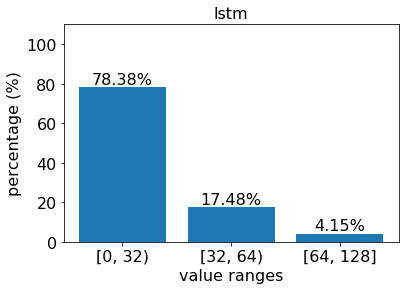

In [59]:
plot_model_dist(quantizer.model)

# fault injection experiments

using GPU: True


In [25]:
def check_directory(path):
    if not os.path.isdir(path):
        os.makedirs(path)

def save_pickle(save_path, save_name, save_object):
    check_directory(save_path)
    filepath = os.path.join(save_path, save_name)
    pickle.dump(save_object, open(filepath,"wb" ))
    print('File saved to:', filepath)

def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))
def write_detailed_info(log_path, info):
    with open(os.path.join(log_path, 'logs.txt'), 'a') as f:
        f.write(info+'\n')

In [26]:
args.model_name = 'lstm'
args.dataset = 'wikitext'
args.data_type = 'int8'
args.fault_type = 'faults_network_rb'

args.save = os.path.join(args.save, args.model_name, args.dataset, args.data_type, args.fault_type) 
if os.path.exists(args.save):
#     shutil.rmtree(args.save)
    print('path already exist! remove path:', args.save)
else:
    os.makedirs(args.save)
print('log will save to:', args.save)
print(args.__dict__)

def select_fault_injection_function():
    fn = {
          'int8': {
              'faults_network_rb': inject_faults_int8_random_bit_position, 
              'faults_network_rb_ps1': inject_faults_int8_random_bit_position_ps1,
              'faults_network_rb_parity_zero': inject_faults_int8_random_bit_position_parity_zero,
              'faults_network_rb_parity_avg': inject_faults_int8_random_bit_position_parity_avg,
              'faults_network_rb_ecc': inject_faults_int8_random_bit_position_ecc,
              'faults_network_rb_bch': inject_faults_int8_random_bit_position_bch,
          }
         }
    return fn[args.data_type][args.fault_type]  
fault_injection_fn = select_fault_injection_function()

path already exist! remove path: ./logs/lstm/wikitext/int8/faults_network_rb
log will save to: ./logs/lstm/wikitext/int8/faults_network_rb
{'save': './logs/lstm/wikitext/int8/faults_network_rb', 'seed': 1, 'dataset': 'wikitext', 'cuda': True, 'fault_type': 'faults_network_rb', 'no_cuda': False, 'data_type': 'int8', 'model_name': 'lstm'}


In [27]:
def get_weights(model):
    # get weights stat    
    weights = [] 
    weights_names = [] 
    for name, param in model.named_parameters():
        # don't do simulation on bias and batch normalization layer
        if len(param.size()) >= 2:
            weights.append(param) 
            weights_names.append(name)
    return weights, weights_names
weights, weights_names = get_weights(quantizer.model)
# weights, weights_names = get_weights(model)
weights_sizes = [param.nelement() for param in weights]
total_values = sum(weights_sizes)
print('# weights params:', len(weights), ', total_values:', total_values)
for i, item in enumerate(zip(weights_names, weights_sizes)):
    print('\t', i, item[0], item[1], '(%f)' %(item[1]/total_values))

# weights params: 6 , total_values: 135834000
	 0 encoder.wrapped_module.weight 49917000 (0.367485)
	 1 rnn.cells.0.fc_gate_x.wrapped_module.weight 9000000 (0.066257)
	 2 rnn.cells.0.fc_gate_h.wrapped_module.weight 9000000 (0.066257)
	 3 rnn.cells.1.fc_gate_x.wrapped_module.weight 9000000 (0.066257)
	 4 rnn.cells.1.fc_gate_h.wrapped_module.weight 9000000 (0.066257)
	 5 decoder.wrapped_module.weight 49917000 (0.367485)


In [28]:
def perturb_weights(model, n_faults, trial_id, log_path, fault_injection_fn): 
    # use trial_id to setup random seed 
    start = time.time()
    np.random.seed(trial_id)
    random = np.random  
    flipped_bits, changed_params, stats = 0, 0, {}
    
    # get the n_bits for each weight 
    weights, _ = get_weights(model)
    weights_sizes = [param.nelement() for param in weights]
    total_values = sum(weights_sizes)
    p = [size/total_values for size in weights_sizes]
    samples = random.choice(len(weights), size=n_faults, p=p)
    counter = collections.Counter(samples)
    
    print('samples:', sorted(counter.items())) 
    
    for weight_id in sorted(counter.keys()):
        param = weights[weight_id]
        tensor = param.data.view(-1)
#         tensor_copy = tensor.clone() 
        
        # flip n_bits number of values from tensor
        n_bits = counter[weight_id]
        res = fault_injection_fn(tensor, random, n_bits)
        stats[weight_id] = res 
        if isinstance(res, tuple):
            flipped_bits += sum([len(arr) for x, arr in stats[weight_id][0].items()])
            changed_params += len(stats[weight_id][0])
#             print('nonzero', torch.nonzero(tensor_copy.view(-1) - tensor.view(-1)).size()[0], len(stats[weight_id][0]))
        else:
            flipped_bits += sum([len(arr) for x, arr in stats[weight_id].items()])
            changed_params += len(stats[weight_id])
#             print('nonzero', torch.nonzero(tensor_copy.view(-1) - tensor.view(-1)).size()[0], len(stats[weight_id]))
    
    assert flipped_bits == n_faults and changed_params <= n_faults, '%d, %d, %d' %(flipped_bits, changed_params, n_faults) 
    
    total_bits = total_values* 8
    info = 'trial: %d, n_faults: %d, total_params: %d' %(trial_id, n_faults, total_values)
    info += ', flipped_bits: %d (%.2e)' %(flipped_bits, flipped_bits*1.0/total_bits)
    info += ', changed_params: %d (%.2e)' %(changed_params, changed_params*1.0/total_values)
    
    end = time.time() - start
    print('Finish fault injection, time (s):', end) 
    
    save_path = os.path.join(log_path, 'stats')
    save_name = str(trial_id) + '.pkl'
    save_pickle(save_path, save_name, stats)
    
    return info  

        

In [30]:
##########################
## start simulation ######
##########################
args.start_trial_id = 0
args.end_trial_id = 10
# for each fault_rate, use fault rate to get the number of faults
print('\nSimulation start: ', datetime.now())
simulation_start = time.time()
# fault_rates = [10**x for x in range(-8, -2, 1)]
fault_rates = [10**-3] 
for fault_rate in fault_rates:
    
    n_faults = int(total_values * 8 * fault_rate)
    if n_faults <= 0: 
        continue
    
    folder = 'r%s' %(fault_rate)
    log_path = os.path.join(args.save, folder)
    check_directory(log_path)
    
    # for each trial, initialize the model  
    for trial_id in range(args.start_trial_id, args.end_trial_id):
        print('\nfault_rate:', fault_rate, ', n_faults:', n_faults, ', trial_id:', trial_id)
        start = time.time()
        quantized_model = deepcopy(quantizer.model)
        quantized_model.cpu()
        
        info = perturb_weights(quantized_model, n_faults, trial_id, log_path, fault_injection_fn) 
        val_loss = evaluate(quantized_model.to(device), val_data)
        ppl = np.exp(val_loss)
        duration = time.time() - start  

        info += ', test_time(s): %d' %(duration)
        info += ', test_loss: %f, perplexity: %f' %(val_loss, ppl)
        print(info, '\n')
        write_detailed_info(log_path, info)
        
        
#         break 
#     break 
simulation_time = time.time() - simulation_start
print('Simulation ends:', datetime.now(), ', duration(s):%.2f' %(simulation_time)) 


Simulation start:  2019-07-31 14:06:27.536585

fault_rate: 0.001 , n_faults: 1086672 , trial_id: 0
samples: [(0, 398670), (1, 71977), (2, 71712), (3, 72330), (4, 72117), (5, 399866)]
sample time (s): 25.7883 , injection_time (s): 55.7231
sample time (s): 4.1941 , injection_time (s): 10.0535
sample time (s): 4.1829 , injection_time (s): 10.4972
sample time (s): 4.2507 , injection_time (s): 10.5609
sample time (s): 4.2025 , injection_time (s): 10.0564
sample time (s): 26.1074 , injection_time (s): 56.9920
Finish fault injection, time (s): 223.13528871536255
File saved to: ./logs/lstm/wikitext/int8/faults_network_rb/r0.001/stats/0.pkl


100%|██████████| 622/622 [02:20<00:00,  4.71it/s, val_loss=4.54, ppl=93.6] 

trial: 0, n_faults: 1086672, total_params: 135834000, flipped_bits: 1086672 (1.00e-03), changed_params: 1082899 (7.97e-03), test_time(s): 375, test_loss: 4.532776, perplexity: 93.016409 

Simulation ends: 2019-07-31 14:12:43.180116 , duration(s):375.64


Here we see that sometimes quantizing with the right boundaries gives better results than actually using floating point operations (even though they are half precision). 

## Conclusion

Choosing the right boundaries for quantization  was crucial for achieving almost no degradation in accrucay of LSTM.  
  
Here we showed how to use the Distiller quantization API to quantize an RNN model, by converting the PyTorch implementation into a modular one and then quantizing each layer separately.

## References

1. **Jongsoo Park, Maxim Naumov, Protonu Basu, Summer Deng, Aravind Kalaiah, Daya Khudia, James Law, Parth Malani, Andrey Malevich, Satish Nadathur, Juan Miguel Pino, Martin Schatz, Alexander Sidorov, Viswanath Sivakumar, Andrew Tulloch, Xiaodong Wang, Yiming Wu, Hector Yuen, Utku Diril, Dmytro Dzhulgakov, Kim Hazelwood, Bill Jia, Yangqing Jia, Lin Qiao, Vijay Rao, Nadav Rotem, Sungjoo Yoo, Mikhail Smelyanskiy**. Deep Learning Inference in Facebook Data Centers: Characterization, Performance Optimizations and Hardware Implications. [arxiv:1811.09886](https://arxiv.org/abs/1811.09886)

2. **Qinyao He, He Wen, Shuchang Zhou, Yuxin Wu, Cong Yao, Xinyu Zhou, Yuheng Zou**. Effective Quantization Methods for Recurrent Neural Networks. [arxiv:1611.10176](https://arxiv.org/abs/1611.10176)